In [1]:
import pandas as pd
import numpy as np

In [2]:
#this is for determining the postal district
#define two search parameters
district = []
bedroom = []

#upload data file for list of postal areas
postal_areas = pd.read_csv("/Users/smu/Desktop/Data Science stuff/rental units project/list-of-postal-districts.csv")

preferred_area = "ang mo kio"
preferred_area = preferred_area.title()

#bedroom number parameter
bedroom = 3

#for i in range(0,len(postal_areas.index)):
district_code = postal_areas[postal_areas["General Location"].str.contains(preferred_area)]
postal_district = int(district_code['Postal District'])

if (postal_district == 0):
    print("Your Area is sadly not in our repository")


In [3]:
from bs4 import BeautifulSoup
import urllib.request
import csv
import requests
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
import random
import time

address = []
pp = []
squarefeet = []

for j in range(1,5):
    
    #extract webpage html, including multiple pages of the webpage
    url1 = 'https://www.iproperty.com.sg/rent/district-' + str(postal_district)+ '/hdb/?bedroom=' + str(bedroom) + '&page=' + str(j)
    headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    page = requests.get(url1,headers= headers)#urllib.request.urlopen(url1)
    soupysoupy = BeautifulSoup(page.text,'html.parser')

    geolocator = Nominatim(user_agent = "Jalaba")
    
    #create temporary address list
    addr = soupysoupy.find_all("div",{'class':'fsKEtj'})
    
    for a in addr:
        data_addr = a.text.strip()
        address.append(data_addr)


    #create price list
    price = soupysoupy.find_all("div",{'class':'hzTrLN'})
    
    for p in price:
        data_price = p.text.strip()
        pp.append(data_price)
    
    #create sqft list 
    sqft = soupysoupy.find_all('a',{'class':'attrs-price-per-unit-desktop'})
    
    for a in sqft:
        data_sqft = a.text.strip()
        squarefeet.append(data_sqft)
    
    time.sleep(random.randint(1,10))

address_df = pd.DataFrame(address,columns=['Address'])
price_df = pd.DataFrame(pp,columns=['Price'])
sqft_df = pd.DataFrame(squarefeet,columns=['Square Feet'])

In [4]:
#combine both dataframes and clean the data a bit
full_data = pd.concat([address_df,price_df,sqft_df],axis=1)

full_data = full_data.replace({'SGD':''},regex=True)
full_data = full_data.replace({',':''},regex = True)
full_data = full_data.replace({'Blk':''},regex = True)
full_data = full_data.replace({'Built-up : ':''},regex = True)

for k in range(0,len(full_data.index)-1):
    if (full_data['Square Feet'][k][-6:] == 'sq. m.'):
        full_data['Square Feet'][k] = full_data['Square Feet'][k].replace(' sq. m.','')
        full_data['Square Feet'][k] = int(full_data['Square Feet'][k]) * 10.764

full_data = full_data.replace({' sq. ft.':''},regex = True)
full_data["Address"] = full_data['Address'].str.slice(0,-7,1)
full_data['Price'] = pd.to_numeric(full_data['Price'])
full_data['Square Feet'] = pd.to_numeric(full_data['Square Feet'])
full_data = full_data.dropna()

print(full_data)

                       Address  Price  Square Feet
0    596B ANG MO KIO STREET 52   2700      916.000
1         146 BISHAN STREET 11   2400      100.000
2         144 BISHAN STREET 12   2600     1313.208
3      648 ANG MO KIO AVENUE 5   2300     1302.000
4      328 ANG MO KIO AVENUE 3   2200      775.008
5     461 ANG MO KIO AVENUE 10   2250      990.000
6         164 BISHAN STREET 13   2650     1300.000
7          402 SIN MING AVENUE   2500     1300.000
8         154 BISHAN STREET 13    800     1300.000
9         109 BISHAN STREET 12   2800     1130.220
10    474 ANG MO KIO AVENUE 10    650      120.000
11     221 ANG MO KIO AVENUE 1    650      120.000
12        146 BISHAN STREET 11   2600      904.000
13     428 ANG MO KIO AVENUE 3    580      110.000
14    700B ANG MO KIO AVENUE 6   2550      950.000
15        288 BISHAN STREET 24    720      110.000
16     573 ANG MO KIO AVENUE 3   2300      990.000
17     343 ANG MO KIO AVENUE 3    630      110.000
18     424 ANG MO KIO AVENUE 3 

In [5]:
#now lets filter out the weird stuff eg rooms that are not accurately labelled

full_data_clean = full_data[(full_data['Square Feet'] > 150 * int(bedroom)) & (full_data['Price'] > 500 * int(bedroom))]
full_data_clean = full_data_clean.reset_index(drop=True)


In [6]:
#create empty lists to store values later on
location = []
lat = []
long = []

geolocator = Nominatim(user_agent="user name here")
#loop through the addresses collected from the website to generate latitude and longitude values
for i in range(0,len(full_data_clean.index)):
    locator = geolocator.geocode(str(full_data_clean['Address'][i]))
    location.append(locator)
    lat.append(location[i][1][0])
    long.append(location[i][1][1])

#create the latitude and longitude dataframes
lat_df = pd.DataFrame(lat,columns=["Latitude"])
long_df = pd.DataFrame(long,columns=["Longitude"])

#combine the lat and long df into the main dataset
full_data_clean = pd.concat([full_data_clean,lat_df,long_df],axis = 1)

#create a map of singapore
location = [1.3521,103.8198]
sgmap = folium.Map(location,zoom_start = 12)

#create a colour coding function
lower_price_bracket = np.percentile(full_data_clean['Price'],30)
mid_price_bracket = np.percentile(full_data_clean['Price'],70)

def colourcode(rent_price):
    if (rent_price < lower_price_bracket):
        return('green')
    elif (rent_price >= lower_price_bracket and rent_price < mid_price_bracket):
        return('orange')
    else:
        return('red')

#store latitude data and longitude data in dataframes
latitude = full_data_clean['Latitude']
longitude = full_data_clean['Longitude']
price = full_data_clean['Price']
address = full_data_clean['Address']

#loop to find the houses on the map using coordinates
for latitude, longitude, address, price in zip(latitude,longitude,address,price):
    folium.Marker(location = [latitude,longitude],popup=str(address) + ' $' + str(price), icon = folium.Icon(color = colourcode(price))).add_to(sgmap)

sgmap

{'whiskers': [<matplotlib.lines.Line2D at 0x121857518>,
 'caps': [<matplotlib.lines.Line2D at 0x121857d68>,
 'boxes': [<matplotlib.lines.Line2D at 0x121843f60>],
 'medians': [<matplotlib.lines.Line2D at 0x1218635f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x121863a20>],
 'means': []}

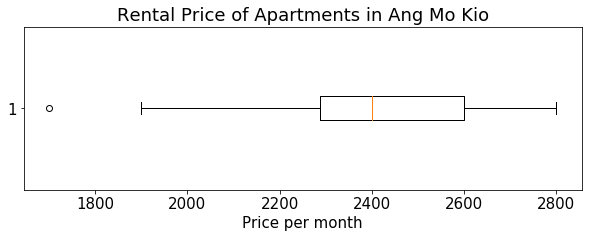

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['font.size'] = '15'
plt.title('Rental Price of Apartments in ' + str(preferred_area))
plt.ylabel('')
plt.xlabel('Price per month')

plt.boxplot(full_data_clean['Price'],vert=False)

(array([1., 2., 1., 2., 1., 5., 5., 6., 5., 4.]),
 array([1700., 1810., 1920., 2030., 2140., 2250., 2360., 2470., 2580.,
        2690., 2800.]),
 <a list of 10 Patch objects>)

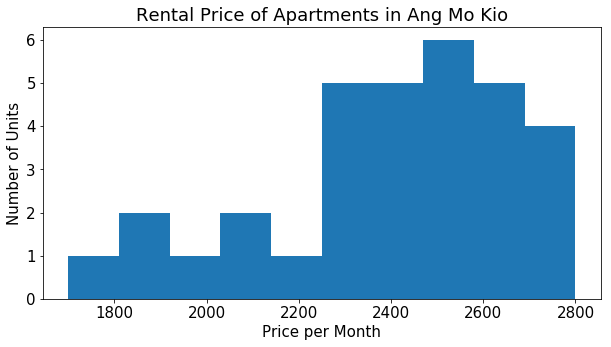

In [8]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = '15'
plt.title('Rental Price of Apartments in ' + str(preferred_area))
plt.xlabel('Price per Month')
plt.ylabel('Number of Units')

plt.hist(full_data_clean['Price'])

In [9]:
full_data

,Address,Price,Square Feet
0,596B ANG MO KIO STREET 52,2700,916.000
1,146 BISHAN STREET 11,2400,100.000
2,144 BISHAN STREET 12,2600,1313.208
3,648 ANG MO KIO AVENUE 5,2300,1302.000
4,328 ANG MO KIO AVENUE 3,2200,775.008
5,461 ANG MO KIO AVENUE 10,2250,990.000
6,164 BISHAN STREET 13,2650,1300.000
7,402 SIN MING AVENUE,2500,1300.000
8,154 BISHAN STREET 13,800,1300.000
9,109 BISHAN STREET 12,2800,1130.220
